In [1]:
from __future__ import print_function
from fenics import *
from dolfin_adjoint import *
# import mshr
import numpy as np
import pathlib
from tqdm import tqdm

### Load created mesh

In [2]:
# Create mesh and define function space
sample_name = "midpoint_ellipse"
filepath = 'test_sample_deform/load/'+sample_name+'/'
out_dir = pathlib.Path(filepath)
out_dir.mkdir(parents=True, exist_ok=True)

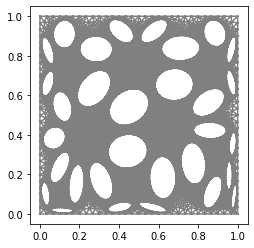

In [3]:
meshpath = './output_files/'
mesh = Mesh()
with XDMFFile(meshpath+sample_name+".xdmf") as xdmf_infile:
    xdmf_infile.read(mesh)
n_elements = mesh.coordinates().shape[0]
plot(mesh)

### Constitutive relation

In [4]:
# Mechanical Properties
E_m = 1e6
E = Constant(1*E_m)
nu = Constant(0.3)
sigma_y0 = Constant(0.01*E_m) # yield stress

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)

In [5]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [6]:
# Constitutive relation
def epsilon(u):
    return sym(grad(u))

def sigma_el(epsilon):
    return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

def sigma_yield(epsilon):
    return sigma_y0 + 0.1*sigma_y0*tanh(epsilon*10)

def epsilon_pl(d_epsilon, sigma_old, epsilon_old,kappa_value=100):
    '''
    inputs
    d_epsilon: strain increment
    sigma_old: stress tensor at the increment n
    epsilon_old: plastic strain tensor
    kappa_value: sharpness of the sigmoid function
    '''
    kappa = Constant(kappa_value)
    
    sigma_y = sigma_yield(epsilon_old)
    H = diff(sigma_y, epsilon_old)
    
    sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
    sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
    sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress
    
    sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
    f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
    f_ind = (f_sigmoid-0.5)*sgn + 0.5
    
    d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
    n_pr = dev(sigma_pr) / sigma_ef
    d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr
    
    return d_epsilon_pl

def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
    d_epsilon_el = epsilon(du) # elastic strain increment
    d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
    d_epsilon = d_epsilon_el - d_epsilon_pl
    dot_p = sqrt(inner(d_epsilon_pl,d_epsilon_pl)*2.0/3.0 + DOLFIN_EPS) #Accumulated plastic strain rate
    return sig_n + sigma_el(d_epsilon), dot_p

In [7]:
def mis_ep(u):
    eps_dev = epsilon(u) - Identity(2)*tr(epsilon(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sig(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

In [8]:
Time = 20
num_steps = 20
e_tot = 0.01

def solve_plastic_system(mesh, Time, num_steps, constitutive_func, loss_func=lambda n,x: 0, tol = 1.0E-14):
    dt = Time / num_steps # time step size
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, tol)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, tol)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    def BC_corner(x, on_boundary):
        return near(x[1], 0, tol) and near(x[0], 0, 5e-2)
    bc_corner = DirichletBC(V.sub(0), 0,    BC_corner)
    
    
    # Time-stepping
    t = 0
    results = []
    
    File_displacement = File(filepath+'displacement_AG.pvd')
    File_stress_Mis = File(filepath+'stress_Mis_AG.pvd')
    File_strain_Mis = File(filepath+'strain_Mis_AG.pvd')
    File_strain_AG = File(filepath+'strain_AG.pvd')
    File_stess_AG = File(filepath+'stess_AG.pvd')
    
    array_u = np.zeros((n_elements,2,num_steps+1))
    array_sigma = np.zeros((n_elements,2,2,num_steps+1))
    array_epsilon = np.zeros((n_elements,2,2,num_steps+1))
    
    for n in tqdm(range(num_steps+1)):
#         print(n)
        displacement = float(e_tot/num_steps*n)
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD, bc_corner]
        
        # Define variational problem
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = t + dt
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
#         print('end')
        
        # Save solution to file in VTK format
        sig_Mis = project(mis_sig(sig),S)
        ep_Mis = project(mis_ep(u),S)
#         sig_Mis = mis_sig(sig)
#         ep_Mis = mis_ep(u)
        epsilon_u = epsilon(u)
        
        u.rename('$u$','displacement')
        sig.rename('$\sigma$','stress')
        ep.rename('$\epsilon$','strain')
        sig_Mis.rename('$\sigma_{VM}$','stress_Mis')
        ep_Mis.rename('$\epsilon_{VM}$','strain_Mis')
        
        File_displacement << (u,t)
        File_stress_Mis << (sig_Mis,t)
        File_strain_Mis << (ep_Mis)
        File_strain_AG << (ep,t)
        File_stess_AG << (sig,t)
        
        # Save element vectors in .mat format
        from scipy.io import savemat
        array_u[:,:,n] = np.array(u.vector()).reshape(n_elements,2)
        
        epsilon_u = epsilon(u)
        epsilon_u = project(epsilon(u),T)
        array_epsilon[:,:,:,n] = np.array(epsilon_u.vector()).reshape(n_elements,2,2)
        
        array_sigma[:,:,:,n] = np.array(sig.vector()).reshape(n_elements,2,2)
        
    mdic = {'u':array_u, 'epsilon':array_epsilon, 'sigma':array_sigma}
    savemat(filepath+'data.mat', mdic)
        
    return ep, sig, u, sig_Mis, ep_Mis

In [9]:
ep, sig, u, sig_Mis, ep_Mis = solve_plastic_system(mesh, Time, num_steps, Constitutive_function)

  0%|                                                                                              | 0/21 [00:00<?, ?it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


  5%|████                                                                                  | 1/21 [00:05<01:42,  5.11s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.609e-11 (tol = 1.000e-10) r (rel) = 3.666e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


 10%|████████▏                                                                             | 2/21 [00:18<03:06,  9.79s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.798e-11 (tol = 1.000e-10) r (rel) = 4.098e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


 14%|████████████▎                                                                         | 3/21 [00:32<03:34, 11.90s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.984e-11 (tol = 1.000e-10) r (rel) = 4.522e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


 19%|████████████████▍                                                                     | 4/21 [00:46<03:36, 12.72s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.078e-11 (tol = 1.000e-10) r (rel) = 4.736e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


 24%|████████████████████▍                                                                 | 5/21 [01:01<03:33, 13.35s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.286e-11 (tol = 1.000e-10) r (rel) = 5.210e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


 29%|████████████████████████▌                                                             | 6/21 [01:14<03:22, 13.47s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.694e-03 (tol = 1.000e-10) r (rel) = 6.139e-07 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 6.357e-07 (tol = 1.000e-10) r (rel) = 1.449e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.


 33%|████████████████████████████▋                                                         | 7/21 [01:35<03:42, 15.88s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.360e+00 (tol = 1.000e-10) r (rel) = 3.100e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.053e-02 (tol = 1.000e-10) r (rel) = 9.238e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.670e-05 (tol = 1.000e-10) r (rel) = 1.520e-08 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 2.917e-07 (tol = 1.000e-10) r (rel) = 6.648e-11 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.


 38%|████████████████████████████████▊                                                     | 8/21 [02:11<04:50, 22.31s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.390e+00 (tol = 1.000e-10) r (rel) = 1.000e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.397e-01 (tol = 1.000e-10) r (rel) = 7.742e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.458e-03 (tol = 1.000e-10) r (rel) = 5.601e-07 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.752e-06 (tol = 1.000e-10) r (rel) = 1.311e-09 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.351e-08 (tol = 1.000e-10) r (rel) = 3.080e-12 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.


 43%|████████████████████████████████████▊                                                 | 9/21 [02:56<05:50, 29.21s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.478e+00 (tol = 1.000e-10) r (rel) = 1.476e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.498e-01 (tol = 1.000e-10) r (rel) = 3.415e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.286e-04 (tol = 1.000e-10) r (rel) = 7.490e-08 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 9.374e-07 (tol = 1.000e-10) r (rel) = 2.136e-10 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.


 48%|████████████████████████████████████████▍                                            | 10/21 [03:30<05:40, 30.92s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.021e+01 (tol = 1.000e-10) r (rel) = 2.326e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.511e-01 (tol = 1.000e-10) r (rel) = 8.002e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.207e-03 (tol = 1.000e-10) r (rel) = 5.031e-07 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.002e-05 (tol = 1.000e-10) r (rel) = 2.283e-09 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 6.760e-08 (tol = 1.000e-10) r (rel) = 1.540e-11 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.


 52%|████████████████████████████████████████████▌                                        | 11/21 [04:11<05:39, 33.91s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.749e+01 (tol = 1.000e-10) r (rel) = 3.986e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.619e+00 (tol = 1.000e-10) r (rel) = 3.689e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.725e-02 (tol = 1.000e-10) r (rel) = 3.931e-06 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 2.155e-05 (tol = 1.000e-10) r (rel) = 4.911e-09 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 4.545e-08 (tol = 1.000e-10) r (rel) = 1.036e-11 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.


 57%|████████████████████████████████████████████████▌                                    | 12/21 [04:52<05:23, 35.95s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.697e+01 (tol = 1.000e-10) r (rel) = 6.146e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.803e+00 (tol = 1.000e-10) r (rel) = 1.322e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.575e-01 (tol = 1.000e-10) r (rel) = 1.726e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 7.087e-03 (tol = 1.000e-10) r (rel) = 1.615e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 8.689e-06 (tol = 1.000e-10) r (rel) = 1.980e-09 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.254e-07 (tol = 1.000e-10) r (rel) = 2.857e-11 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


 62%|████████████████████████████████████████████████████▌                                | 13/21 [05:40<05:17, 39.75s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.147e+01 (tol = 1.000e-10) r (rel) = 9.450e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 8.334e+00 (tol = 1.000e-10) r (rel) = 1.899e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.994e-01 (tol = 1.000e-10) r (rel) = 1.138e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.108e-01 (tol = 1.000e-10) r (rel) = 2.525e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 4.034e-04 (tol = 1.000e-10) r (rel) = 9.192e-08 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.633e-06 (tol = 1.000e-10) r (rel) = 3.721e-10 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


 67%|████████████████████████████████████████████████████████▋                            | 14/21 [06:30<04:59, 42.80s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.111e+01 (tol = 1.000e-10) r (rel) = 1.165e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 8.363e+00 (tol = 1.000e-10) r (rel) = 1.906e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.497e-01 (tol = 1.000e-10) r (rel) = 1.025e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.007e-02 (tol = 1.000e-10) r (rel) = 2.294e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.397e-05 (tol = 1.000e-10) r (rel) = 7.740e-09 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 8.627e-08 (tol = 1.000e-10) r (rel) = 1.966e-11 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


 71%|████████████████████████████████████████████████████████████▋                        | 15/21 [07:22<04:32, 45.45s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.388e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.668e+01 (tol = 1.000e-10) r (rel) = 1.292e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.218e+01 (tol = 1.000e-10) r (rel) = 2.775e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.128e-01 (tol = 1.000e-10) r (rel) = 1.396e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 6.716e-03 (tol = 1.000e-10) r (rel) = 1.530e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.876e-05 (tol = 1.000e-10) r (rel) = 4.275e-09 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 3.050e-07 (tol = 1.000e-10) r (rel) = 6.951e-11 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


 76%|████████████████████████████████████████████████████████████████▊                    | 16/21 [08:11<03:53, 46.73s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.389e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.418e+01 (tol = 1.000e-10) r (rel) = 1.462e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.357e+01 (tol = 1.000e-10) r (rel) = 3.093e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.540e-01 (tol = 1.000e-10) r (rel) = 1.718e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.476e-02 (tol = 1.000e-10) r (rel) = 7.920e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 9.590e-05 (tol = 1.000e-10) r (rel) = 2.185e-08 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 5.661e-07 (tol = 1.000e-10) r (rel) = 1.290e-10 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


 81%|████████████████████████████████████████████████████████████████████▊                | 17/21 [09:01<03:11, 47.77s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.389e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.030e+01 (tol = 1.000e-10) r (rel) = 1.602e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.565e+01 (tol = 1.000e-10) r (rel) = 3.567e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 8.878e-01 (tol = 1.000e-10) r (rel) = 2.023e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.135e-01 (tol = 1.000e-10) r (rel) = 2.587e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.315e-03 (tol = 1.000e-10) r (rel) = 7.553e-07 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.260e-05 (tol = 1.000e-10) r (rel) = 2.870e-09 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 3.241e-08 (tol = 1.000e-10) r (rel) = 7.384e-12 (tol = 1.000e-09)
  Newton solver finished in 7 iterations and 7 linear solver iterations.


 86%|████████████████████████████████████████████████████████████████████████▊            | 18/21 [09:59<02:32, 50.87s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.389e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.303e+01 (tol = 1.000e-10) r (rel) = 1.664e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.780e+01 (tol = 1.000e-10) r (rel) = 4.055e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.013e+00 (tol = 1.000e-10) r (rel) = 2.309e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.595e-01 (tol = 1.000e-10) r (rel) = 3.635e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.995e-03 (tol = 1.000e-10) r (rel) = 9.102e-07 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.146e-05 (tol = 1.000e-10) r (rel) = 4.890e-09 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 1.409e-07 (tol = 1.000e-10) r (rel) = 3.210e-11 (tol = 1.000e-09)
  Newton solver finished in 7 iterations and 7 linear solver iterations.


 90%|████████████████████████████████████████████████████████████████████████████▉        | 19/21 [11:03<01:49, 54.79s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.389e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.597e+01 (tol = 1.000e-10) r (rel) = 1.731e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.057e+01 (tol = 1.000e-10) r (rel) = 4.687e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.031e+00 (tol = 1.000e-10) r (rel) = 2.350e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.688e-01 (tol = 1.000e-10) r (rel) = 3.846e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 5.270e-03 (tol = 1.000e-10) r (rel) = 1.201e-06 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 1.218e-05 (tol = 1.000e-10) r (rel) = 2.775e-09 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 2.758e-08 (tol = 1.000e-10) r (rel) = 6.283e-12 (tol = 1.000e-09)
  Newton solver finished in 7 iterations and 7 linear solver iterations.


 95%|████████████████████████████████████████████████████████████████████████████████▉    | 20/21 [12:01<00:55, 55.61s/it]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.389e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.784e+01 (tol = 1.000e-10) r (rel) = 1.773e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.215e+01 (tol = 1.000e-10) r (rel) = 5.046e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 9.598e-01 (tol = 1.000e-10) r (rel) = 2.187e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 9.544e-02 (tol = 1.000e-10) r (rel) = 2.175e-05 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.298e-03 (tol = 1.000e-10) r (rel) = 2.958e-07 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 7.961e-07 (tol = 1.000e-10) r (rel) = 1.814e-10 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


100%|█████████████████████████████████████████████████████████████████████████████████████| 21/21 [12:53<00:00, 36.85s/it]


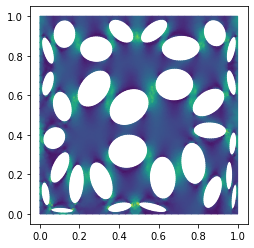

In [10]:
S = FunctionSpace(mesh, 'P', 2)
sigma_Mis = project(mis_sig(sig),S)
plot(sig_Mis, mode='color')